# Fatbox for Analogue Modelling - Fault extraction from PIV-derived elevation - tuto 1/6

This example describes how to extract a 2-D fault network from a single timestep obtained from an analogue model simulating orthogonal continental rifting.

The analog models are based on the study of Molnar et al. (2017)

### Load packages
To run the toolbox, we will need a couple of packages including the toolbox itself. So let's install it:

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pwd

Mounted at /content/drive
/content


In [2]:
!pip install earthpy
!pip install cv-algorithms
!pip install vtk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 63.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for cv-algorithms: filename=cv_algorithms-1.1.1-cp311-cp311-manylinux_2_35_x86_64.whl size=40946 sha256=5a7405c2c5a7d9fbd09ee546bfaca91b3753cecc38460ce97b549c0c4147e8a2
  Stored in directory: /root/.cache/pip/wheels/6d/fc/8d/7dc6a93ee79ff25fd3491eac76e255cca24893bb3d5f3cc150
Successfully built cv-algorithms
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.1/112.1 MB 7.3 MB/s eta 0:00:00


Now we can load the python packages that we need:

In [3]:
import numpy as np
import networkx as nx
import cv2

import copy
import tqdm

import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from skimage import data, io, filters, measure, feature, color, morphology
from skimage.morphology import skeletonize
from skimage.util import invert, img_as_ubyte

from scipy.spatial import distance_matrix
from scipy import interpolate
from scipy.interpolate import griddata
from scipy.signal import fftconvolve, savgol_filter
from scipy import ndimage as ndi

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

from pathlib import Path #The gestion of Path with pathlib allows for universal use.
import os
path_folder=Path('/content/drive/MyDrive/Fatbox')
path_modules=path_folder/'modules'
#print(path_modules) #make sure path_modules = '/Fatbox/modules'
os.chdir(path_modules) # make modules as working directory
#type pwd in console and make sure it is '/Fatbox/modules'

import preprocessing
import metrics
import plots
import utils
import structural_analysis
import edits

save_plots=False
loc_plots=Path(path_folder/'tutorials'/'analog'/'plots'/'B1')
my_dpi=100

if not (path_folder/'tutorials'/'analog'/'plots'/'B1').is_dir():
    (path_folder/'tutorials'/'analog'/'plots'/'B1').mkdir(parents=True,exist_ok=True)


### Load data
In this example, we have a dataset consisting of 16 DEM numpy arrays obtained from cleaning and cropping the data exported from the PIV software

In [4]:
path_input=Path(path_folder/'tutorials'/'analog'/'data_analog')

dem = np.load((path_input/'dem15.npy')) #our dem array will be stored here
dem_1 = np.load((path_input/'dem16.npy')) #our dem array will be stored here

dem = dem[:,:-1] #added this line because the canny edge detection algorithm was generating an unreal 'fault' in the right hand side of the arrays
dem_1 = dem_1[:,:-1]

## 1. Fault Extraction

First let's plot our raw data to see what are we looking at:

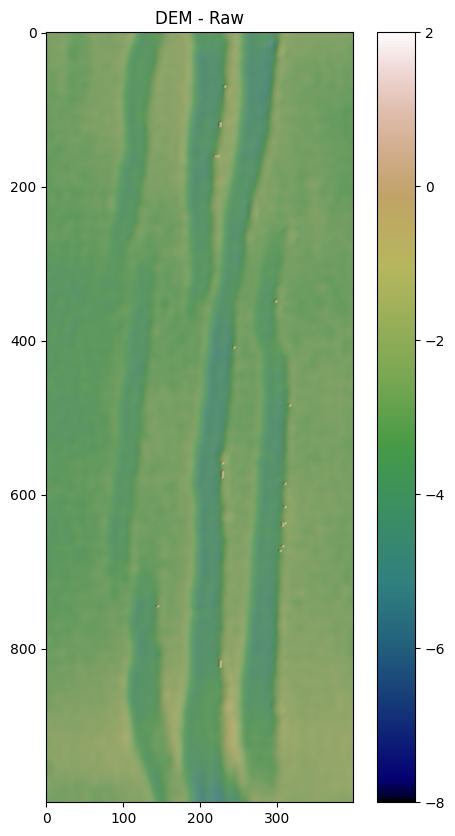

In [5]:
#First we define a few variables to calculate a hillshade for our DEMs
az = 300 #azimuth of the light for the hillshade
alt = 1 #altitute (degrees) of the light for the hillshade

plt.figure(figsize=(6,10)) #set up plot
hillshade = es.hillshade(dem, azimuth=az, altitude=alt) #create hillshade for better visualisation
plt.title('DEM - Raw')
plt.imshow(dem, cmap='gist_earth', vmin=-8, vmax=2) #try 'cubehelix' as an alternative
plt.colorbar()
plt.imshow(hillshade, cmap='Greys', alpha=0.3)
plt.show()

Before moving on to the image analysis and fault detection, we can apply a Gaussian blur filter to smooth the surface a little bit in order to get better results (especially considering that PIV data is usually exported with certain irregularities) by reducing the noise:

In [6]:
def gaussian_blur(in_array, size):
    # expand in_array to fit edge of kernel
    padded_array = np.pad(in_array, size, 'symmetric')
    # build kernel
    x, y = np.mgrid[-size:size + 1, -size:size + 1]
    g = np.exp(-(x**2 / float(size) + y**2 / float(size)))
    # do the Gaussian blur
    g = (g / g.sum()).astype(in_array.dtype)
    return fftconvolve(padded_array, g, mode='valid')

And plot both to see the difference:

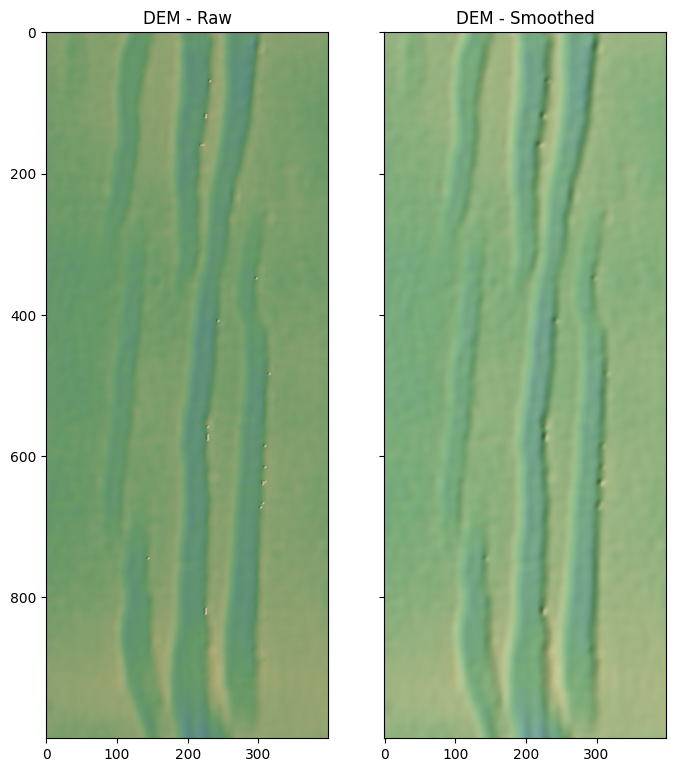

In [7]:
blurfact = 15 #the higher this number is, the more we will smooth the DEM
blurdem = gaussian_blur(dem, blurfact)

hillshade = es.hillshade(dem, azimuth=az, altitude=alt) #create hillshade for better visualisation, same variables as before
blurhillshade = es.hillshade(blurdem, azimuth=az, altitude=alt) #create hillshade for better visualisation, same variables as before

fig, axs = plt.subplots(1, 2, figsize=(8, 10), sharex=True, sharey=True) # set up plot

axs[0].imshow(dem,cmap='gist_earth', vmin=-8, vmax=2) #plot raw DEM
axs[0].imshow(hillshade, cmap='Greys', alpha=0.4) #add hillshade
axs[0].set_title('DEM - Raw', fontsize=12)

axs[1].imshow(blurdem,cmap='gist_earth', vmin=-8, vmax=2) #plot smoothed DEM
axs[1].imshow(blurhillshade, cmap='Greys', alpha=0.4)
axs[1].set_title('DEM - Smoothed', fontsize=12)

if save_plots: plt.savefig((loc_plots/'1_DEM_raw_smooth.png'),dpi=my_dpi)


Next step is to apply a canny edge detection, which basically consists of detecting intensity gradients in an image (in this case, that change will be equivalent to a fault):

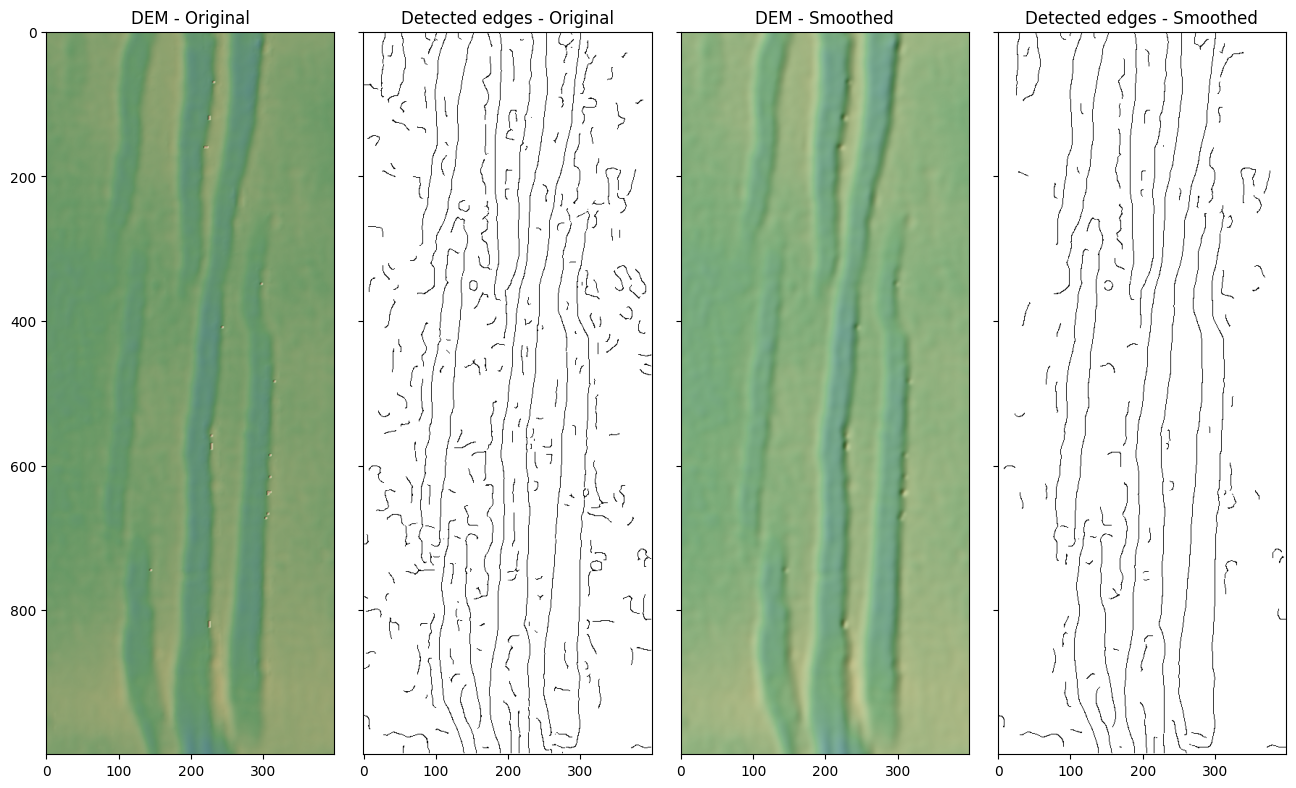

In [8]:
#These parameters can and should be modified depending on the dataset.
#You can manually vary them and compare the results!
sigma = 3 #lower number, more faults detected but more noise too
lowth = 0.15
highth = 0.2

faultsraw = feature.canny(dem, sigma=sigma, low_threshold=lowth, high_threshold=highth)
faultsblur = feature.canny(blurdem, sigma=sigma, low_threshold=lowth, high_threshold=highth)

fig, axs = plt.subplots(1, 4, figsize=(16, 10), sharex=True, sharey=True) # set up plot

axs[0].imshow(dem, cmap='gist_earth', vmin=-8, vmax=2) #plot raw DEM
axs[0].imshow(hillshade, cmap='Greys', alpha=0.4)
axs[0].set_title('DEM - Original', fontsize=12)

axs[1].imshow(faultsraw, cmap='Greys') #plot what we detect from applying canny edge detection to raw DEM
axs[1].set_title('Detected edges - Original', fontsize=12)

axs[2].imshow(blurdem,cmap='gist_earth', vmin=-8, vmax=2) #plot smoothed DEM
axs[2].set_title('DEM - Smoothed', fontsize=12)
axs[2].imshow(blurhillshade, cmap='Greys', alpha=0.4)

axs[3].imshow(faultsblur, cmap='Greys') #plot what we detect from applying canny edge detection to smoothed DEM
axs[3].set_title('Detected edges - Smoothed', fontsize=12)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()
if save_plots: plt.savefig((loc_plots/'2_DEM_edges_raw_smooth.png'),dpi=my_dpi)


From the figure we can notice the effect of applying the blur filter to smooth our DEM data. While technically it involves slightly modifying the elevation data, the result after applying the canny edge detection shows that faults are identified in the exact same position as for the original DEM.

We therefore keep this step as it help us clean the data before converting the lines into a graph using Fatbox.
______

## Converting 'image' of faults to network (nodes and edges)

Another important point is that while the fault traces look like if they were 1-pixel thick lines, they are not.
We must perform a skeletonization to make sure we are reducing everything to nodes (1 pixel) next:




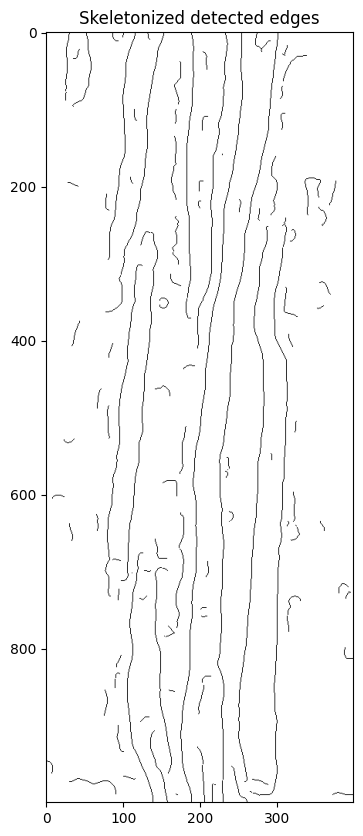

In [9]:
faults = img_as_ubyte(faultsblur) #convert faults arrays to another format, otherwise the skeleton fx won't work
skeleton = preprocessing.skeleton_guo_hall(faults) #skeletonize

#plot
plt.figure(figsize=(6,10))
plt.title('Skeletonized detected edges')
plt.imshow(skeleton, cmap='Greys')
plt.show()
if save_plots: plt.savefig((loc_plots/'3_skeleton_smooth.png'),dpi=my_dpi)


Now we can convert these lines to points:

In [10]:
points = preprocessing.array_to_points(skeleton)

These points become the nodes of our graph G:

In [11]:
G = nx.Graph()

for node, point in enumerate(points):
    G.add_node(node)
    G.nodes[node]['pos'] = point

Remember a graph is an object consisting only of nodes and edges. Our graph for example looks like this:

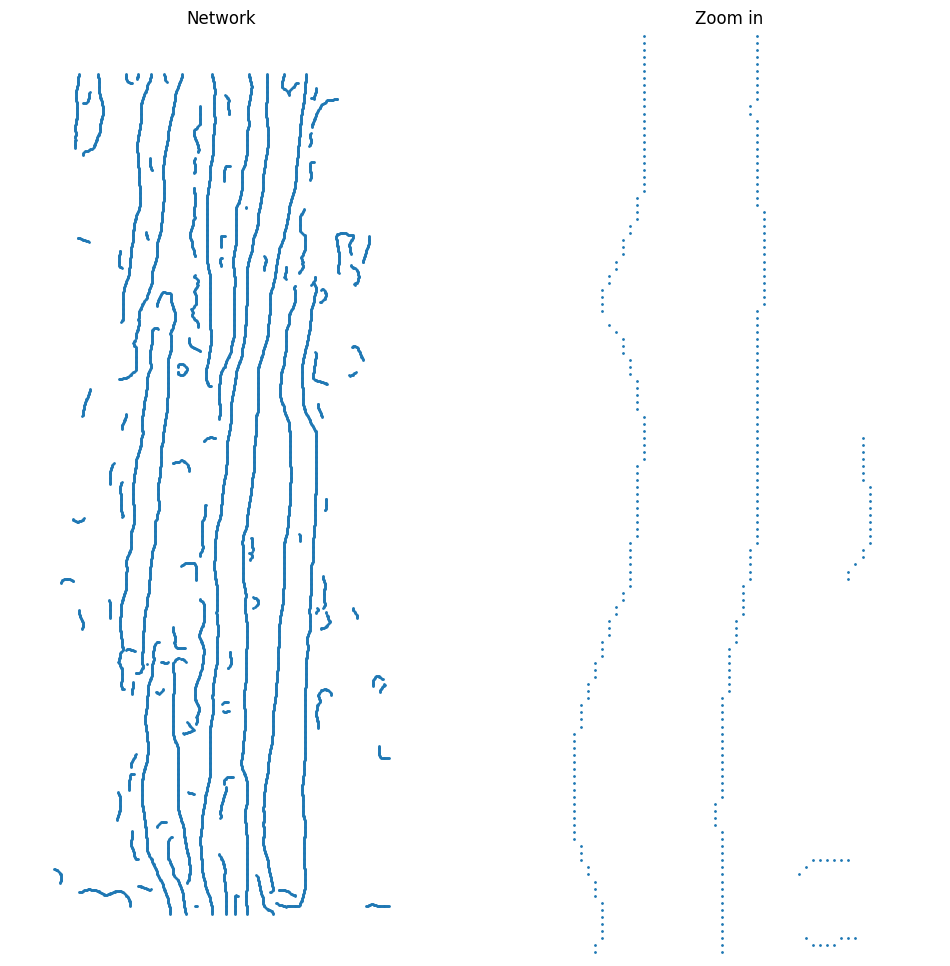

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12,12))

axs[0].set_title('Network')
nx.draw(G,
        pos=nx.get_node_attributes(G, 'pos'),
        node_size=1,
        ax=axs[0])
axs[0].axis('equal')
axs[0].invert_yaxis()

axs[1].set_title('Zoom in')
nx.draw(G,
        pos=nx.get_node_attributes(G, 'pos'),
        node_size=1,
        ax=axs[1])
axs[1].axis('equal')
axs[1].set_xlim([160, 220]) #Adjust if a different area needs to be zoomed in
axs[1].set_ylim([670, 720]) #Adjust if a different area needs to be zoomed in
axs[1].invert_yaxis()

plt.show()
if save_plots: plt.savefig((loc_plots/'4_network_zoomin.png'),dpi=my_dpi)


You can see that the graph only consists of closely spaced points, which are not yet connected. So let's change that!


We calculate the distance between all nodes in a distance matrix and connect the ones close to each other (<1.5 pixels away):

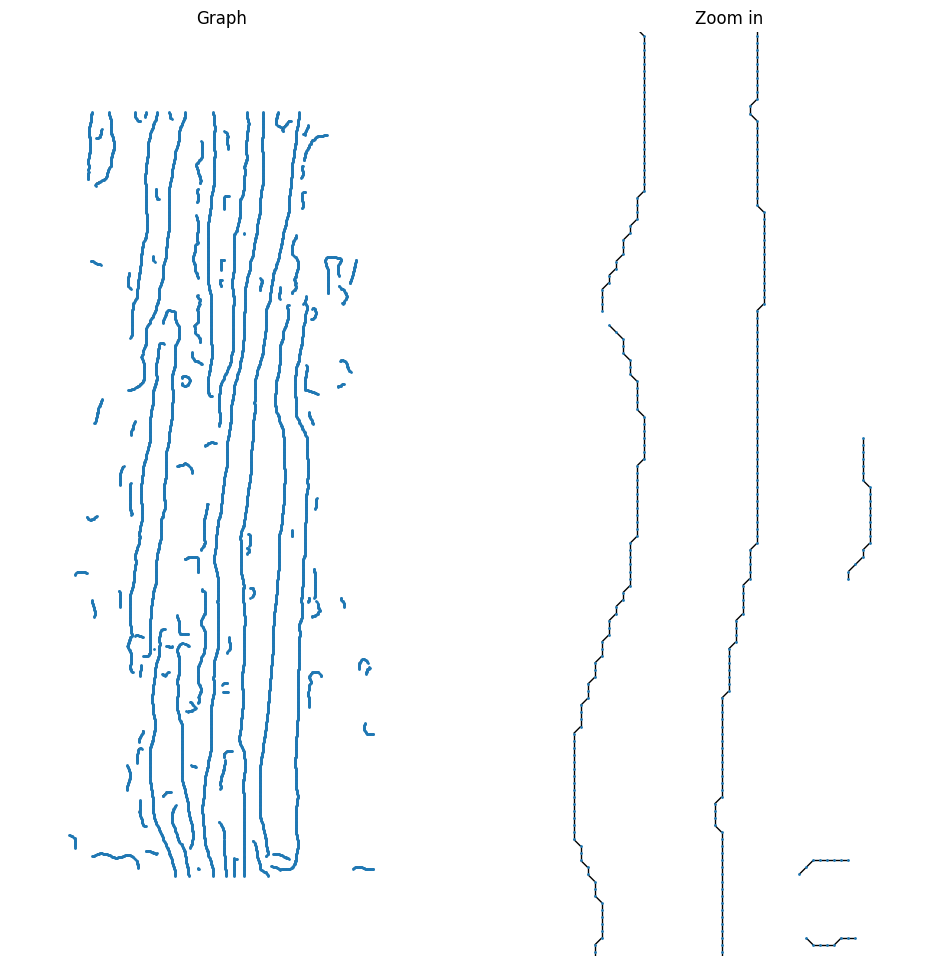

In [13]:
ret, markers = cv2.connectedComponents(skeleton) #get connected components from the skeletonised image

node = 0
for comp in range(1,ret):
  points = np.transpose(np.vstack((np.where(markers==comp))))

  for point in points:
      G.add_node(node)
      G.nodes[node]['pos'] = (point[1], point[0])
      G.nodes[node]['component'] = comp
      node += 1

for comp in range(1,ret):

  points = [G.nodes[node]['pos'] for node in G if G.nodes[node]['component']==comp]
  nodes  = [node for node in G if G.nodes[node]['component']==comp]

  dm = distance_matrix(points, points)

  for o in range(len(points)):

      for m in range(len(points)):
          if dm[o,m]<1.5 and o != m:
              G.add_edge(nodes[o],nodes[m])

#These 5 lines remove nodes that are connected with multiple edges, we don't want that! We need to identify each line/trace as a single fault
for node in list(G.nodes()):
  if G.degree(node) == 3 or G.degree(node) == 4 or G.degree(node) == 5: #remove nodes with 3, 4, 5 edges
      edges = list(G.edges(node))
      G.add_edge(edges[0][1], edges[1][1])
      G.remove_node(node)

#plot to see if we see the same
fig, axs = plt.subplots(1, 2, figsize=(12,12))

axs[0].set_title('Graph')
nx.draw(G,
        pos=nx.get_node_attributes(G, 'pos'),
        node_size=1,
        ax=axs[0])
axs[0].axis('equal')
axs[0].invert_yaxis()

axs[1].set_title('Zoom in')
nx.draw(G,
        pos=nx.get_node_attributes(G, 'pos'),
        node_size=1,
        ax=axs[1])
axs[1].axis('equal')
axs[1].set_xlim([160, 220]) #Adjust if a different area needs to be zoomed in
axs[1].set_ylim([670, 720]) #Adjust if a different area needs to be zoomed in
axs[1].invert_yaxis()

plt.show()
if save_plots: plt.savefig((loc_plots/'5_network_connected_zoomin.png'),dpi=my_dpi)


Now we can see that neighboring nodes are connected by edges (black lines). This allows us to label the nodes connected to one another as components:

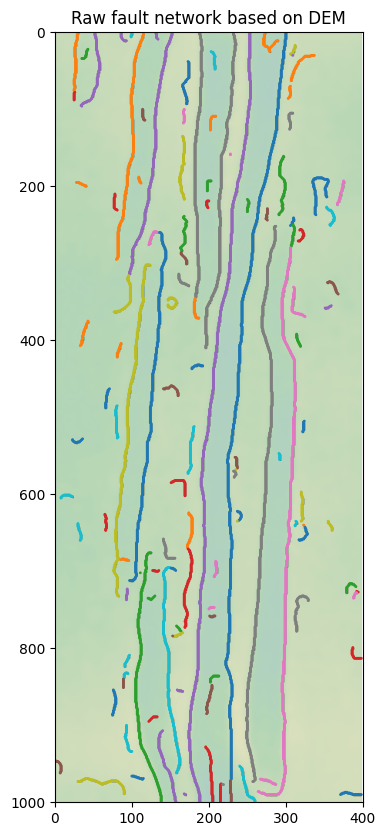

In [14]:
import plots
G = edits.label_components(G)

fig, axs = plt.subplots(1, 1, figsize=(5,10))
axs.imshow(blurdem, 'gist_earth',vmin=-8, vmax=2, alpha=0.4)
plots.plot_components(G, False, node_size=1, ax=plt.axes(axs))
axs.set_ylim([1000,0])
axs.set_xlim([0,400])
plt.title('Raw fault network based on DEM')
plt.show()
if save_plots: plt.savefig((loc_plots/'6_raw_network_DEM.png'),dpi=my_dpi)

That is a bit crowded. Let's clean up the network, using two main filters:

**First filter:** Curves, sharp turns, or 'U-shaped' faults are not a single, continuous fault trace. We can use the strike of each edge as a parameter to remove nodes with a significant change of direction:

In [18]:
# First we need to define a set of auxiliary functions to calculate strike difference,
# which is used as a parameter to clean the network

def calculate_mystrike(G, non):
    """ Compute strike of fault network

    Parameters
    ----------
    G : nx.graph
        Graph containing edges
    non: int
        Number of neighbors

    Returns
    -------
    G : nx.graph
        Graph containing edges with 'strike' attribute
    """

    # Assertions
    assert isinstance(G, nx.Graph), 'G is not a NetworkX graph'

    for node in tqdm.tqdm(G, desc='Calculate mystrike'):


        neighbors = nx.single_source_shortest_path_length(G, node, cutoff=non)


        neighbors = sorted(neighbors.items())

        first = neighbors[0][0]
        last = neighbors[-1][0]

        # print(node)
        # print(neighbors)
        # print(first, last)



        x1 = G.nodes[first]['pos'][0]
        y1 = G.nodes[first]['pos'][1]

        x2 = G.nodes[last]['pos'][0]
        y2 = G.nodes[last]['pos'][1]


        G.nodes[node]['strike'] = metrics.strike(x1, y1, x2, y2)


    for edge in G.edges:
        G.edges[edge]['strike'] = (G.nodes[edge[0]]['strike'] + G.nodes[edge[0]]['strike'])/2

    return G

#function 3
def calculate_diff_strike(G, non):
    """ Compute strike difference between nodes of fault network

    Parameters
    ----------
    G : nx.graph
        Graph containing edges
    non: int
        Number of neighbors

    Returns
    -------
    G : nx.graph
        Graph containing nodes with 'strike' attribute
    """


    # Assertions
    assert isinstance(G, nx.Graph), 'G is not a NetworkX graph'


    for node in G:

        neighbors = nx.single_source_shortest_path_length(G, node, cutoff=non)
        #print(neighbors)
        #print(len(neighbors))
        strikes = [G.nodes[node]['strike'] for node in neighbors.keys()]
        #print(strikes)
        #print(len(strikes))
        if len(neighbors) > 1:
          G.nodes[node]['strike_diff'] = np.max(np.diff(strikes))
        else:
          G.nodes[node]['strike_diff'] = np.nan


    return G

# function 4

def remove_nodes_between(G, attribute, low, high):
    """ Remove node with attribute between two values

    Parameters
    ----------
    G : nx.graph
        Graph
    attribute : str
        Attribute
    low : float
        lower value
    high : float
        higher value

    Returns
    -------
    G : nx.graph
        Graph
    """
    removals = []
    # Assertions
    assert isinstance(G, nx.Graph), "G is not a NetworkX graph"

    # Calculation
    for node in G.nodes:
        if G.nodes[node][attribute] >= low and G.nodes[node][attribute] <= high:
            removals.append(node)

    G.remove_nodes_from(removals)

    return G

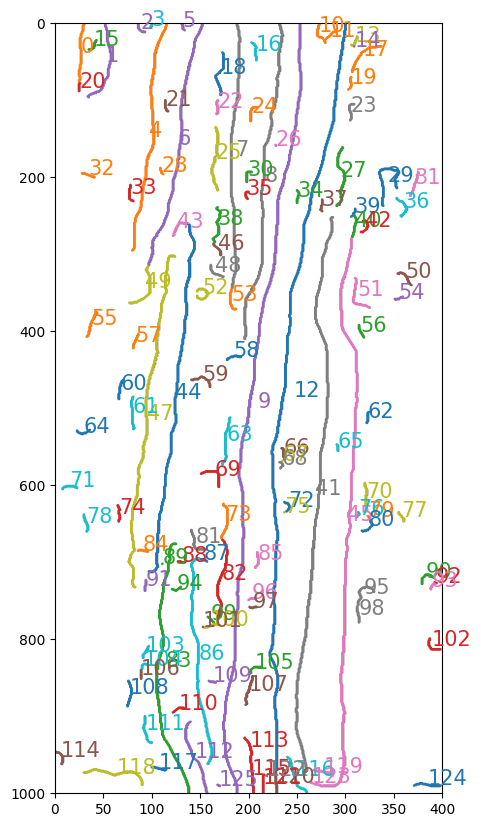

In [16]:
fig, axs = plt.subplots(1, 1, figsize=(5,10))
axs.set_ylim([1000,0])
axs.set_xlim([0,400])
plots.plot_components(G,True,ax=axs,node_size=0.8)

And now we apply those functions and compare the result with our original DEM:

Calculate mystrike: 100%|██████████| 9117/9117 [00:00<00:00, 101142.82it/s]


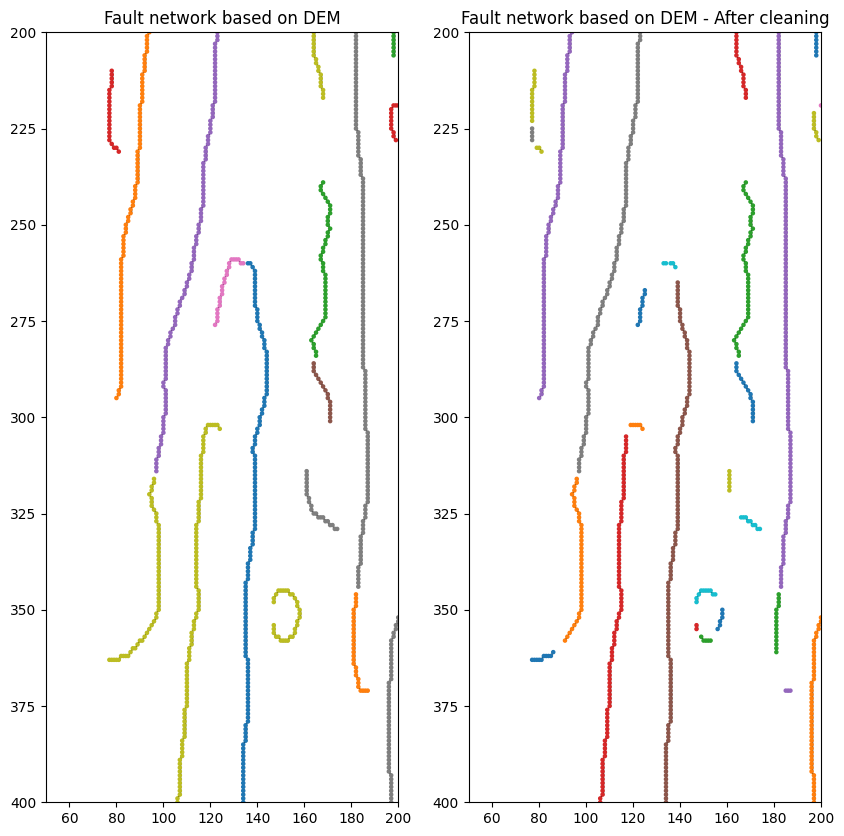

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(10,10), sharey=True, sharex=True)

#we first plot the last graph G
plots.plot_components(G,False, node_size=5.1, ax=plt.axes(axs[0]))
axs[0].set_title('Fault network based on DEM')
axs[0].set_ylim([400,200]) #zoom in
axs[0].set_xlim([50,200]) #zoom in

#and then we apply these nodes removal lines and plot in the second subplot

non1 = 2 #number of neighbour edges taken into account to calculate edge strike
non2 = 12 #number of neighbour edges taken into account to calculate edge strike difference

G = calculate_mystrike(G, non1) #we calculate the strike for each node/edge
G = calculate_diff_strike(G, non2) #we calculate the difference in strike between one edge and the neighbour edge at distance=non2 (number of neighbours)
G = remove_nodes_between(G, attribute='strike_diff', low=60, high=120) #remove all nodes that have a strike difference between 'low' and 'high'

G = edits.label_components(G)

for node in G:
  G.nodes[node]['fault'] = G.nodes[node]['component'] #make component ID and fault ID match

plots.plot_components(G, False, node_size=5, ax=plt.axes(axs[1]))
axs[1].set_title('Fault network based on DEM - After cleaning')
plt.show()
#if save_plots: plt.savefig((loc_plots/'7_Graph_cleaning.png'),dpi=my_dpi)

In this zoomed in figures we can see how a highly curved line will be split into smaller segments.

Now we can apply the second filter, which consists in determining a fault length threshold and getting rid of all the faults smaller than that value:

Total number of faults: 200
Faults shorter than 40 : 172
Remaining faults: 28


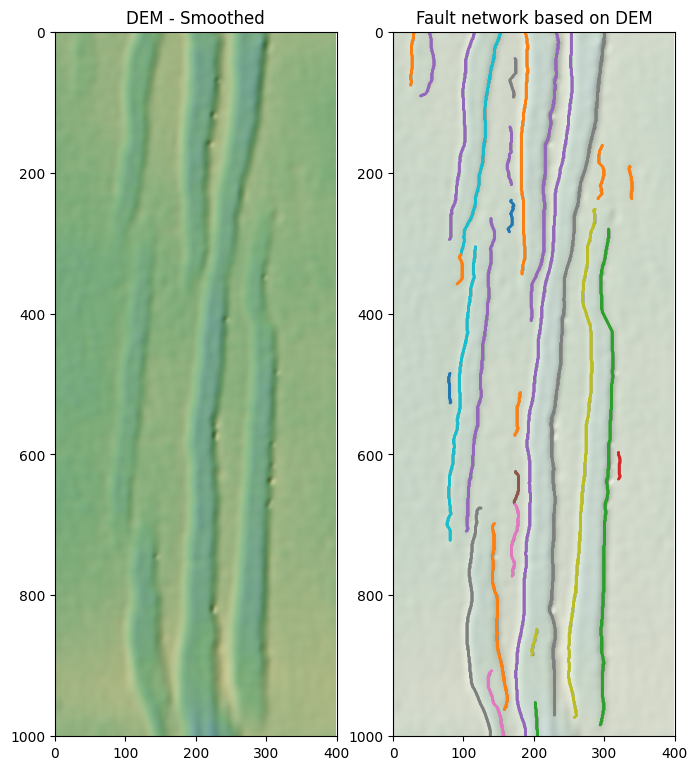

In [20]:
f_thr = 40 #define the threshold

def get_fault_labels(G):
  labels=set()
  for nodex in G:
      labels.add(G.nodes[nodex]['fault'])
  return sorted(list(labels))

fault_labels = get_fault_labels(G)

f_len = metrics.calculate_fault_lengths(G, mode='get') #get fault lengths for cleaning them by length in the following step
f_id_clean = np.argwhere(f_len<f_thr) #get faults with a length smaller than the threshold

#print a little summary of each timestep to see how things are working out
print("Total number of faults: " + str(len(f_len)))
print("Faults shorter than " + str(f_thr) + " : " + str(len(f_id_clean)))
print("Remaining faults: " + str(len(f_len)-len(f_id_clean)))

for e in range(len(f_id_clean)): #number of times we are going to loop this, which is the number of faults that meet our condition
  fid = f_id_clean.item(e) #get a temporary variable, fid = fault id
  for node in G.copy():
    if G.nodes[node]['fault'] == fid: #if the fault id's match
      G.remove_node(node) #remove all nodes associated to that fault id

G = edits.label_components(G)

fig, axs = plt.subplots(1, 2, figsize=(8,10), sharex=True, sharey=True)

axs[0].imshow(blurdem,cmap='gist_earth', vmin=-8, vmax=2) #plot smoothed DEM
axs[0].set_title('DEM - Smoothed', fontsize=12)
axs[0].imshow(blurhillshade, cmap='Greys', alpha=0.4)

axs[1].imshow(blurdem, 'gist_earth', vmin=-8, vmax=2, alpha=0.3)
axs[1].imshow(blurhillshade, cmap='Greys', alpha=0.4)
axs[1].set_ylim([1000,0])
axs[1].set_xlim([0,400])
plots.plot_components(G, False, node_size=1, ax=axs[1])
plt.title('Fault network based on DEM')
plt.show()
#if save_plots: plt.savefig((loc_plots/'8_smooth_cleaning.png'),dpi=my_dpi)

**And we have our fault network!**

.
______

# 2. Correlating between time steps

What happens with the fault IDs when we start working with more than one time step?

If we don't correlate them, then we will be identifying all faults with new IDs for each timestep, meaning that fault #5 at time t won't necessarily be fault #5 at time t+1. Let's see how this is done between two time steps.

.

______

To correlate faults across time steps, we want to check if a fault from the time step 0 is within a fault from time step 1 and vice versa. This allows us to correlate faults even if they merge or split up.

*(See [Tutorial A3](https://github.com/thilowrona/fatbox_tutorials/blob/main/Numerical_models/3-time_stepping/3-time_stepping.ipynb) for a detailed explanation)*

To correlate faults across time steps, we want to check how similar each fault from time step 0 is to each fault from time step 1. This will allow us to correlate fault even if they merge or split up between time steps. To do this, we first calculate the similarity and then correlate faults if their similarity is above a certain threshold:



In [21]:
G_0 = copy.deepcopy(G) #we make a copy of the graph we just created and call it G_0

#And before doing the correlation, we need to follow all the same steps as before for our other graph!
#at this point, we only have the original dem16.npy array corresponding to the next time step
#We are going to copy and paste all the relevant lines of code, adding the _1 to each variable to avoid overwriting:

blurdem_1 = gaussian_blur(dem_1, blurfact)
blurhillshade_1 = es.hillshade(blurdem_1, azimuth=az, altitude=alt) #create hillshade for better visualisation, same variables as before
faultsblur_1 = feature.canny(blurdem_1, sigma=sigma, low_threshold=lowth, high_threshold=highth)

faults_1 = img_as_ubyte(faultsblur_1) #convert faults arrays to another format, otherwise the skeleton fx won't work
skeleton_1 = preprocessing.skeleton_guo_hall(faults_1) #skeletonize

points_1 = preprocessing.array_to_points(skeleton_1)

G = nx.Graph()

for node, point in enumerate(points):
    G.add_node(node)
    G.nodes[node]['pos'] = point

ret, markers = cv2.connectedComponents(skeleton_1) #get connected components from the skeletonised image

node = 0
for comp in range(1,ret):
  points = np.transpose(np.vstack((np.where(markers==comp))))

  for point in points:
      G.add_node(node)
      G.nodes[node]['pos'] = (point[1], point[0])
      G.nodes[node]['component'] = comp
      node += 1

for comp in range(1,ret):

  points = [G.nodes[node]['pos'] for node in G if G.nodes[node]['component']==comp]
  nodes  = [node for node in G if G.nodes[node]['component']==comp]

  dm = distance_matrix(points, points)

  for o in range(len(points)):

      for m in range(len(points)):
          if dm[o,m]<1.5 and o != m:
              G.add_edge(nodes[o],nodes[m])

#These 5 lines remove nodes that are connected with multiple edges, we don't want that! We need to identify each line/trace as a single fault
for node in list(G.nodes()):
  if G.degree(node) == 3 or G.degree(node) == 4 or G.degree(node) == 5: #remove nodes with 3, 4, 5 edges
      edges = list(G.edges(node))
      G.add_edge(edges[0][1], edges[1][1])
      G.remove_node(node)

G = edits.label_components(G)

G = calculate_mystrike(G, non1) #we calculate the strike for each node/edge
G = calculate_diff_strike(G, non2) #we calculate the difference in strike between one edge and the neighbour edge at distance=non2 (number of neighbours)
G = remove_nodes_between(G, attribute='strike_diff', low=60, high=120) #remove all nodes that have a strike difference between 'low' and 'high'

G = edits.label_components(G)

for node in G:
  G.nodes[node]['fault'] = G.nodes[node]['component'] #make component ID and fault ID match

fault_labels = metrics.get_fault_labels(G)

f_len = metrics.calculate_fault_lengths(G, mode='get') #get fault lengths for cleaning them by length in the following step
f_id_clean = np.argwhere(f_len<f_thr) #get faults with a length smaller than the threshold

for e in range(len(f_id_clean)): #number of times we are going to loop this, which is the number of faults that meet our condition
  fid = f_id_clean.item(e) #get a temporary variable, fid = fault id
  for node in G.copy():
    if G.nodes[node]['fault'] == fid: #if the fault id's match
      G.remove_node(node) #remove all nodes associated to that fault id

G = edits.label_components(G)

G_1 = copy.deepcopy(G) #and we make a copy and call it G_1

Calculate mystrike: 100%|██████████| 9530/9530 [00:00<00:00, 54369.46it/s]


Now we plot them to compare:

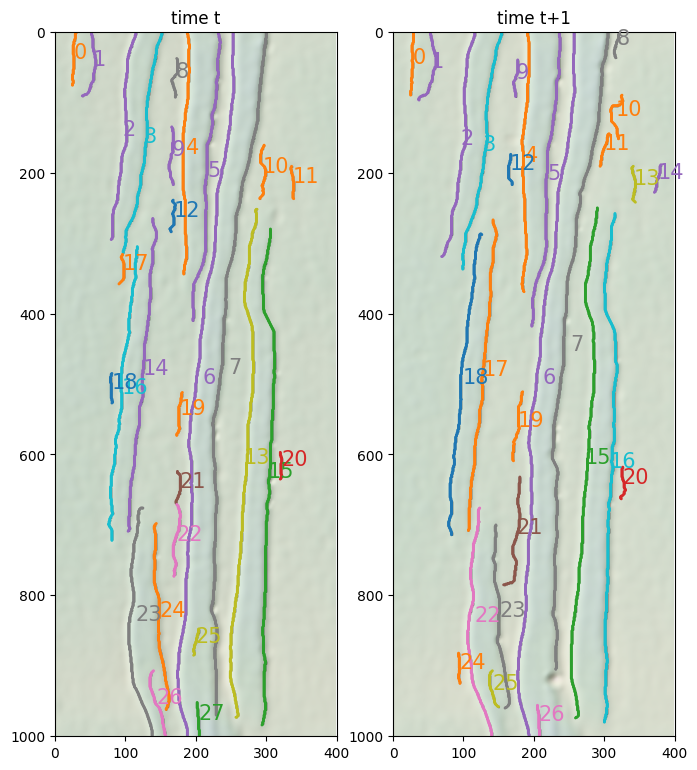

In [22]:
#Summary:
#G_0 is the fault network extracted from the dem we just worked with (originally dem15.npy)
#G_1 is the fault network extracted from the following dem (originally dem16.npy)

fig, axs = plt.subplots(1,2,figsize=(8,12), sharey=True, sharex=True)

plots.plot_components(G_0, node_size=1, ax=axs[0])
axs[0].set_title('time t')
axs[0].set_ylim([1000,0])
axs[0].set_xlim([0,400])
axs[0].imshow(blurdem, 'gist_earth', vmin=-8, vmax=2, alpha=0.3)
axs[0].imshow(blurhillshade, cmap='Greys', alpha=0.4)

plots.plot_components(G_1, node_size=1, ax=axs[1])
axs[1].set_title('time t+1')
axs[1].imshow(blurdem_1, 'gist_earth', vmin=-8, vmax=2, alpha=0.3)
axs[1].imshow(blurhillshade_1, cmap='Greys', alpha=0.4)

plt.show()
if save_plots: plt.savefig((loc_plots/'9_correlation_t_t1.png'),dpi=my_dpi)

We can see that the networks look good and the level of 'cleanliness' is similar, but the fault IDs do not match between timesteps.
_____

First we have to introduce a new label. We typically extract faults as components of the graph (i.e. nodes connected to one another). But geological faults can consist of multiple of such components. So let's introduce this new label called 'fault' based on the components:

In [23]:
for node in G_0:
    G_0.nodes[node]['fault'] = G_0.nodes[node]['component']

for node in G_1:
    G_1.nodes[node]['fault'] = G_1.nodes[node]['component']

And we define some functions we need for the next steps:

In [24]:
def get_nodes(G):
    labels = metrics.get_fault_labels(G)
    point_set=[]
    for label in labels:
        G_fault = metrics.get_fault(G, label)
        points = []
        for node in G_fault:
            points.append(G_fault.nodes[node]['pos'])
        point_set.append(points)
    return point_set

def compute_similarity(set_A, set_B):
      distances = np.zeros((len(set_A), len(set_B)))
      for n, pt_0 in enumerate(set_A):
          for m, pt_1 in enumerate(set_B):
              distances[n,m] = math.sqrt((pt_0[0]-pt_1[0])**2 + (pt_0[1]-pt_1[1])**2)
      return np.mean(np.min(distances, axis=1))

def correlation_slow(G_0, G_1, R):
    # A function which labels the faults in G_1 according to G_0 using the
    # minimum radius R

    # Get labels and nodes
    fault_labels_0 = metrics.get_fault_labels(G_0)
    fault_labels_1 = metrics.get_fault_labels(G_1)

    nodes_0 = get_nodes(G_0)
    nodes_1 = get_nodes(G_1)

    # Compute similarities
    smf = np.zeros((len(fault_labels_0), len(fault_labels_1)))
    smb = np.zeros((len(fault_labels_1), len(fault_labels_0)))

    for n in tqdm.tqdm(range(len(fault_labels_0)), desc='   Compute similarities'):
        for m in range(len(fault_labels_1)):
            smf[n,m] = compute_similarity(nodes_0[n], nodes_1[m])
            smb[m,n] = compute_similarity(nodes_1[m], nodes_0[n])

    # Determine correlations
    correlations = set()
    for n in tqdm.tqdm(range(len(fault_labels_0)), desc='   Find correlations'):
        for m in range(len(fault_labels_1)):
            if smf[n,m] < R:
                correlations.add((fault_labels_0[n], fault_labels_1[m]))
            if smb[m,n] < R:
                correlations.add((fault_labels_0[n], fault_labels_1[m]))

    return correlations, smf, smb

In [25]:
def G_to_pts(G):
    labels = metrics.get_fault_labels(G)
    point_set=[]
    for label in labels:
        G_fault = metrics.get_fault(G, label)
        points = []
        for node in G_fault:
            points.append(G_fault.nodes[node]['pos'])
        point_set.append(points)
    return point_set

def is_A_in_B(set_A, set_B, R):
      distances = np.zeros((len(set_A), len(set_B)))
      for n, pt_0 in enumerate(set_A):
          for m, pt_1 in enumerate(set_B):
              distances[n,m] = math.sqrt((pt_0[0]-pt_1[0])**2 + (pt_0[1]-pt_1[1])**2)
      if np.mean(np.min(distances, axis=1)) > R:
          return False
      else:
          return True

Now we are ready to run a correlation. The key parameter here is R, the radius we are going to consider to look for similar nodes between timesteps.

In [26]:
R = 10
correlations, smf, smb = correlation_slow(G_0, G_1, R=R)

   Find correlations: 100%|██████████| 28/28 [00:00<00:00, 34279.19it/s]


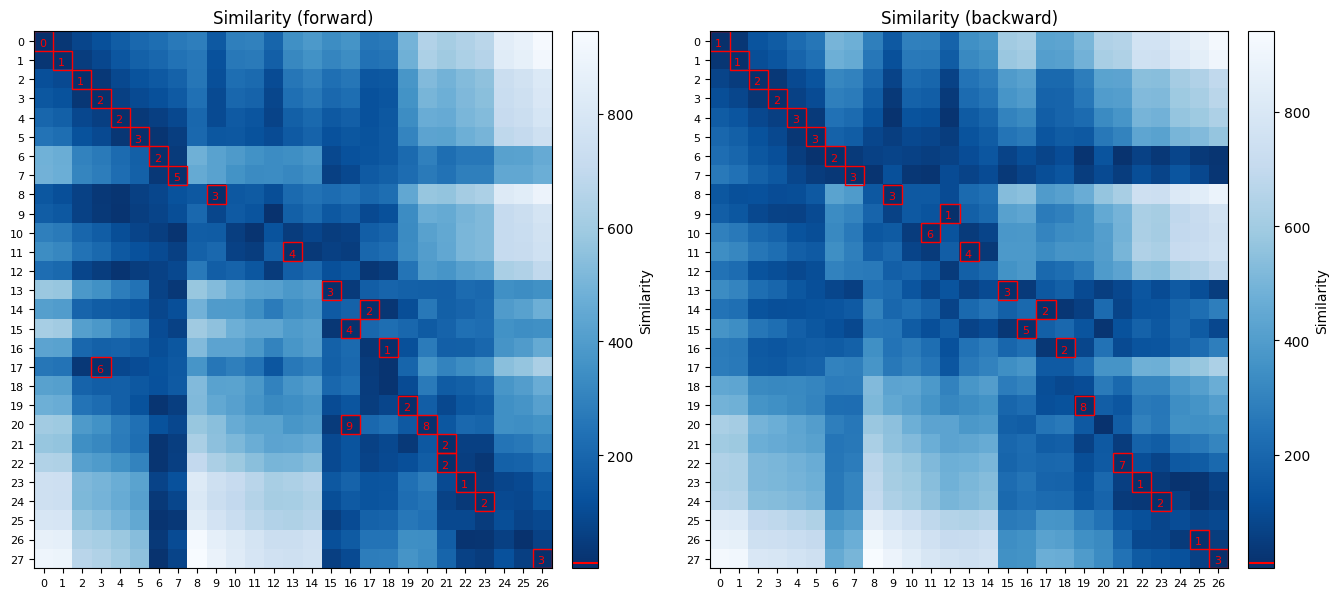

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(16,8))

axs[0].set_title('Similarity (forward)')
im_0 = axs[0].imshow(smf, cmap='Blues_r')
axs[0].set_yticks(range(smf.shape[0]))
axs[0].set_yticklabels(get_fault_labels(G_0), fontsize=8)
axs[0].set_xticks(range(smf.shape[1]))
axs[0].set_xticklabels(get_fault_labels(G_1), fontsize=8)

divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.2)
cbar = fig.colorbar(im_0, cax=cax, orientation='vertical')
cbar.set_label('Similarity')

cbar.ax.plot([0, 800], [R]*2, 'r')

for x in range(smf.shape[0]):
    for y in range(smf.shape[1]):
        if smf[x,y] < R:
            axs[0].text(y-0.25,x+0.25, int(smf[x,y]), color='red', fontsize=8)
            rect = patches.Rectangle((y-0.5, x-0.5), 1, 1, linewidth=1, edgecolor='r', facecolor='none')
            axs[0].add_patch(rect)
        else:
            pass

axs[1].set_title('Similarity (backward)')
im_1 = axs[1].imshow(np.transpose(smb), cmap='Blues_r')
axs[1].set_yticks(range(smf.shape[0]))
axs[1].set_yticklabels(get_fault_labels(G_0), fontsize=8)
axs[1].set_xticks(range(smf.shape[1]))
axs[1].set_xticklabels(get_fault_labels(G_1), fontsize=8)

divider = make_axes_locatable(axs[1])
cax = divider.append_axes('right', size='5%', pad=0.2)
cbar = fig.colorbar(im_1, cax=cax, orientation='vertical')
cbar.set_label('Similarity')

cbar.ax.plot([0, 800], [R]*2, 'r')

for x in range(smb.shape[0]):
    for y in range(smb.shape[1]):
        if smb[x,y] < R:
            axs[1].text(x-0.25,y+0.25, int(smb[x,y]), color='red', fontsize=8)
            rect = patches.Rectangle((x-0.5, y-0.5), 1, 1, linewidth=1, edgecolor='r', facecolor='none')
            axs[1].add_patch(rect)
        else:
            pass

plt.show()
if save_plots: plt.savefig((loc_plots/'10_correlation_similarity.png'),dpi=my_dpi)

Note that we get two similarity matrices, because we compare faults from both time steps forward and backward in time.

Most importantly, we can check whether most faults are correlated and then adjust the value R if necessary. R is a measure for the minimal distance between faults to be correlated, so higher values loosen the correlation and lower values tighten it.

Moreover, we can check the correlation directly:

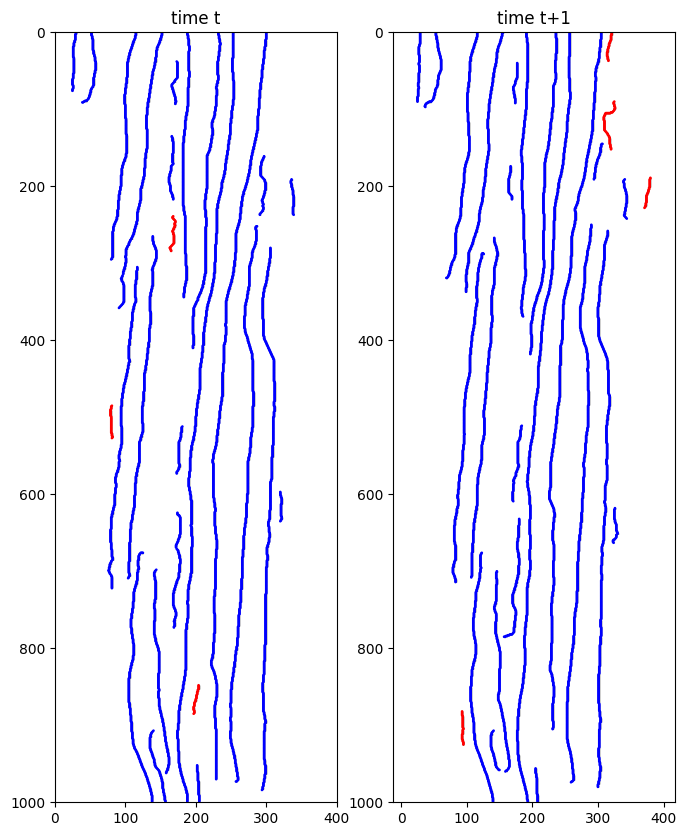

In [28]:
cmap_rb = matplotlib.colors.ListedColormap(['red', 'blue'])

for node in G_0:
    if G_0.nodes[node]['fault'] in [corr[0] for corr in correlations]:
        G_0.nodes[node]['correlated'] = 1
    else:
        G_0.nodes[node]['correlated'] = 0

for node in G_1:
    if G_1.nodes[node]['fault'] in [corr[1] for corr in correlations]:
        G_1.nodes[node]['correlated'] = 1
    else:
        G_1.nodes[node]['correlated'] = 0

fig, axs = plt.subplots(1,2,figsize=(8,10), sharey=True, sharex=False)
axs[0].set_title('time t')
axs[0].set_ylim([1000,0])
axs[0].set_xlim([0,400])
plots.plot_attribute(G_0, 'correlated',colorbar=False, cmap=cmap_rb, vmin=0, vmax=1, ax=axs[0])

axs[1].set_title('time t+1')
plots.plot_attribute(G_1, 'correlated', colorbar=False, cmap=cmap_rb, vmin=0, vmax=1, ax=axs[1])
plt.show()
if save_plots: plt.savefig((loc_plots/'11_correlation_comparison_t_t1.png'),dpi=my_dpi)

Looks good! Red faults are those that are not found in both time steps, so they won't be correlated and will have a different fault ID.

Let's define the function to relabel faults in time step 1 to match time step 0:

In [29]:
def relabel(G_1, correlations):

    # A function, which relabels G_1 using the correlations
    for node in G_1:
        G_1.nodes[node]['correlated']=0

    lengths = [metrics.total_length(metrics.get_fault(G_0, correlation[0]), calculate=True) for correlation in correlations]
    lengths, correlations = zip(*sorted(zip(lengths, correlations)))

    for node in G_1:
        for correlation in correlations:
            if G_1.nodes[node]['component'] == correlation[1]:
                G_1.nodes[node]['fault'] = correlation[0]
                G_1.nodes[node]['correlated'] = 1

    max_comp = max(get_fault_labels(G_1))

    G_1_sub = nx.subgraph(G_1, [node for node in G_1 if G_1.nodes[node]['correlated']==0])
    for label, cc in enumerate(sorted(nx.connected_components(G_1_sub))):
        for n in cc:
            G_1.nodes[n]['fault'] = label+max_comp+1

    return G_1

Then aply it to G_1 and plot:

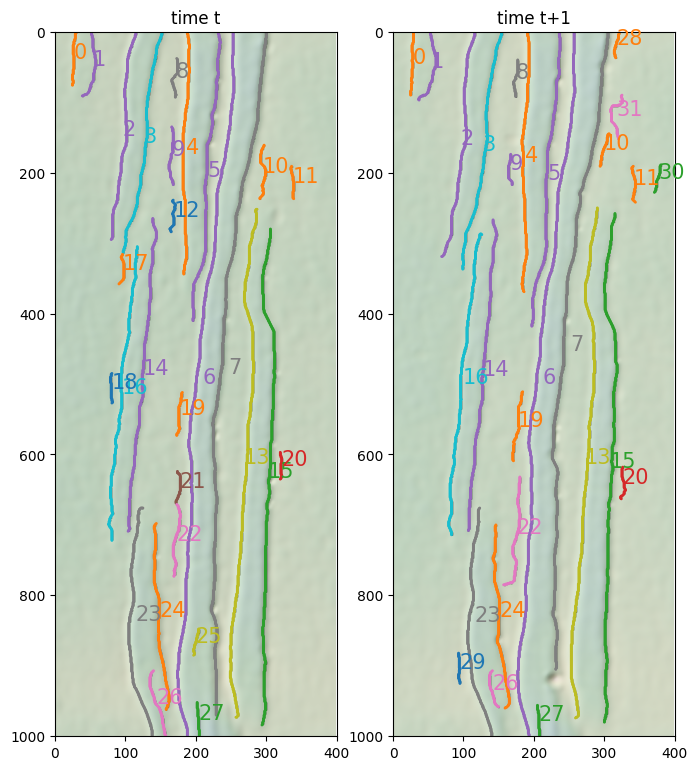

In [30]:
G_1 = relabel(G_1, correlations)

fig, axs = plt.subplots(1,2,figsize=(8,12), sharey=True, sharex=True)
plots.plot_faults(G_0, node_size=1, ax=axs[0])
axs[0].imshow(blurdem, 'gist_earth', vmin=-8, vmax=2, alpha=0.4)
axs[0].imshow(blurhillshade, cmap='Greys', alpha=0.4)
axs[0].set_title('time t')
axs[0].set_ylim([1000,0])
axs[0].set_xlim([0,400])

plots.plot_faults(G_1, node_size=1, ax=axs[1])
axs[1].set_title('time t+1')
axs[1].imshow(blurdem_1, 'gist_earth', vmin=-8, vmax=2, alpha=0.4)
axs[1].imshow(blurhillshade_1, cmap='Greys', alpha=0.4)
plt.show()
if save_plots: plt.savefig((loc_plots/'12_correlation_comparison_t_t1.png'),dpi=my_dpi)

**NICE!**

So if we have a dataset corresponding to multiple time steps, we will need to run this fault correlation for all time steps.

An example of how to do this is given in Tutorial B2.